# StyleGAN2

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
import copy
import os
import random
import time

In [2]:
class MinibatchStdDev(nn.Module):
    def __init__(self, in_channels, group_size=4, epsilon=1e-8):
        super().__init__()

        self.in_channels = in_channels
        self.group_size = group_size
        self.epsilon = epsilon
    
    def forward(self, x):
        assert self.group_size <= x.shape[0]

        B, C, H, W = x.shape
        
        assert B % self.group_size == 0

        y = x.view(self.group_size, -1, C, H, W)              # GMCHW
        y = y - y.mean(dim=0, keepdim=True)                   # GMCHW
        y = torch.sqrt(y.square().mean(dim=0) + self.epsilon) # MCHW
        y = y.mean(dim=[1, 2, 3], keepdim=True)               # M111
        y = y.repeat(self.group_size, 1, H, W)                # B1HW
        y = torch.cat([x, y], dim=1)                          # B(C+1)HW

        return y

MinibatchStdDev(10)(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 11, 4, 4])

## Equalized Learning Rate

$\^{w} = w_i \times \sqrt{\frac{2}{k \times k \times c}}$

$k \times k \times c = $ filters size

In [3]:
class EqualizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(1/(kernel_size * kernel_size * in_channels))

    def forward(self, x):
        return torch.conv2d(x, self.weight * self.scale, self.bias, self.stride, self.padding)

EqualizedConv2d(10, 20, 3, 1, 0)(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 20, 2, 2])

In [4]:
class EqualizedLinear(nn.Linear):
    def __init__(self, in_features, out_features, lr_multiplier=1, bias_init=0.):
        super().__init__(in_features, out_features)

        nn.init.normal_(self.weight, mean=0, std=1./lr_multiplier)
        nn.init.constant_(self.bias, bias_init)

        self.weight_scale = lr_multiplier * np.sqrt(1/in_features)
        self.bias_scale = lr_multiplier
    
    def forward(self, x):
        weight = self.weight * self.weight_scale
        bias = self.bias * self.bias_scale if self.bias_scale != 1 else self.bias
        
        return F.linear(x, weight, bias)

EqualizedLinear(20, 10)(torch.randn(32, 20)).shape

torch.Size([32, 10])

## Pixelwise Feature Vector Normalization In Generator

$b_{x, y} = a_{x, y} / \sqrt{\frac{1}{N} \sum^{N-1}_{j=0} (a_{x, y}^j)^2 + \epsilon}$

In [5]:
class PixelwiseFeatureVectorNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()

        self.epsilon = epsilon

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)


PixelwiseFeatureVectorNormalization()(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 10, 4, 4])

## Mapping Network

In [6]:
class NoiseMappingNetwork(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim, num_layers=8, lr_multiplier=0.01):
        super().__init__()

        assert num_layers >= 2

        self.net = nn.Sequential(
            PixelwiseFeatureVectorNormalization()
        )

        for i in range(num_layers):
            in_features = z_dim if i == 0 else hidden_dim
            out_features = w_dim if i == num_layers-1 else hidden_dim
            self.net.append(EqualizedLinear(in_features, out_features, lr_multiplier=lr_multiplier))
            self.net.append(nn.LeakyReLU(negative_slope=0.2))
    
    def forward(self, z):
        return self.net(z)


NoiseMappingNetwork(512, 512, 512)(torch.randn(64, 512)).shape

torch.Size([64, 512])

## Stochastic variation

In [7]:
class RandomNoiseInjection(nn.Module):
    def __init__(self, num_channels):
        super().__init__()

        # self.weight = torch.nn.Parameter(torch.zeros([])) # changed from (1, num_channels, 1, 1) to only a single parameter
        self.weight = torch.nn.Parameter(torch.zeros((1, num_channels, 1, 1)))
    
    def forward(self, image, noise=None):
        assert noise is None or (type(noise) == torch.Tensor and noise.shape == (image.size(0), 1, image.size(2), image.size(3)))

        if noise is None:
            noise = torch.randn((image.size(0), 1, image.size(2), image.size(3))).to(image.device)

        return image + self.weight * noise


print(RandomNoiseInjection(512)(torch.randn(64, 512, 4, 4)).shape)
print(RandomNoiseInjection(512)(torch.randn(64, 512, 4, 4), noise=torch.randn(64, 1, 4, 4)).shape)

torch.Size([64, 512, 4, 4])
torch.Size([64, 512, 4, 4])


## Weight Demodulation

<img src="weight_demodulation.JPG" width=1000>

$w'_{ijk} = s_i \times w_{ijk}$ 

$s_i:$ scale of the $i$ th input feature map $\;\;-\;\;$ $j :$ output feature map $\;\;-\;\;$ $k :$ spatial footprint of the convolution


Standard deviation of output activations $\longrightarrow \sigma_j = \sqrt{\sum_{i,k} {{w'}_{ijk}}^2}$

$w''_{ijk} = w'_{ijk} / \sqrt{\sum_{i,k} {{w'}_{ijk}}^2 + \epsilon}$

In [8]:
class WeightDemodulationConv2d(nn.Conv2d):
    def __init__(self, w_dim, in_channels, out_channels, kernel_size, stride, padding, demodulate=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.demodulate = demodulate

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(1/(kernel_size * kernel_size * in_channels))

        self.style_scale_transform = EqualizedLinear(w_dim, in_channels, bias_init=1.)

    def forward(self, x, w):
        B, C, H, W = x.shape
        out_channels, in_channels, kh, kw = self.weight.shape
        
        weight = self.weight * self.scale # OIKK

        styles = self.style_scale_transform(w) # BI

        if self.demodulate:
            w = weight.unsqueeze(0) * styles.view(B, 1, in_channels, 1, 1) # _OIKK x B_I__ = BOIKK
            denominator_coef = (w.square().sum(dim=[2, 3, 4]) + 1e-8).rsqrt() # BO

        x = x * styles.view(B, in_channels, 1, 1) # BIHW x BI__ = BIHW
        
        out = torch.conv2d(x, weight, None, self.stride, self.padding) # BOh'w'

        if self.demodulate:
            out = out * denominator_coef[:, :, None, None] # BOh'w' x BO__ = BOh'w'

        out = out + self.bias[None, :, None, None]

        return out


print(WeightDemodulationConv2d(512, 10, 20, 3, 1, 0, demodulate=False)(torch.randn(32, 10, 4, 4), torch.randn(32, 512)).shape)
WeightDemodulationConv2d(512, 10, 20, 3, 1, 0, demodulate=True)(torch.randn(32, 10, 4, 4), torch.randn(32, 512)).shape

torch.Size([32, 20, 2, 2])


torch.Size([32, 20, 2, 2])

## Up/Down Sampling

In [9]:
BLUR_FILTER = torch.tensor([
    [0.0625, 0.125 , 0.0625],
    [0.125 , 0.25  , 0.125 ],
    [0.0625, 0.125 , 0.0625]
])[None, None, :, :]

class Blur(nn.Module):
    def __init__(self, filter=BLUR_FILTER):
        super().__init__()

        self.filter = nn.Parameter(filter, requires_grad=False)
    
    def forward(self, x):
        x = nn.functional.conv2d(
            x,
            weight=self.filter.expand(x.shape[1], -1, -1, -1),
            bias=None,
            padding='same',
            groups=x.shape[1]
        )

        return x

**[Note]** in the StyleGAN implementation, they have used *Blur* layers before downsampling (down_conv) and after upsampling (up_conv). However, we won't do this in this implementation. We just simply use `AvgPool2d` and `Upsample(mode='bilinear')`.

## Truncation Trick

In [10]:
class TruncationSampling(nn.Module):
    def __init__(self, w_avg, psi=0.7, beta=0.995):
        super().__init__()

        self.psi = psi
        self.beta = beta

        self.register_buffer('w_avg', w_avg)
    
    def update(self, w_avg_new):
        self.w_avg.copy_(self.beta * self.w_avg + (1. - self.beta) * w_avg_new)
    
    def forward(self, w):
        return torch.lerp(self.w_avg, w, self.psi)
    

truncation_sampling = TruncationSampling(w_avg=torch.zeros(512, dtype=torch.float))

print(truncation_sampling.w_avg.mean())
print(truncation_sampling(torch.ones(512, dtype=torch.float) * 10).mean())

truncation_sampling.update(w_avg_new=torch.ones(512) * 1000.)

print(truncation_sampling.w_avg.mean())
print(truncation_sampling(torch.ones(512, dtype=torch.float) * 10).mean())

tensor(0.)
tensor(7.)
tensor(5.)
tensor(8.5000)


## Generator

<img src="generator_initial_block.JPG" width=300>

In [11]:
class GeneratorInitialBlock(nn.Module):
    def __init__(self, out_channels, w_dim):
        super().__init__()

        self.starting_constant = nn.Parameter(torch.ones((1, out_channels, 4, 4)))
        self.constant_bias = nn.Parameter(torch.ones(out_channels))
        
        self.conv = WeightDemodulationConv2d(w_dim, out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.noise = RandomNoiseInjection(out_channels)
        self.act = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, w, injected_noise=None):
        out = self.starting_constant.expand(w.shape[0], -1, -1, -1) + self.constant_bias.view(1, -1, 1, 1)
        
        out = self.conv(out, w)
        out = self.noise(out, injected_noise)
        out = self.act(out)

        return out


GeneratorInitialBlock(512, 256)(torch.randn(4, 256)).shape

torch.Size([4, 512, 4, 4])

<img src="generator_block.JPG" width=300>

In [12]:
class GeneratorBlock(nn.Module):
    def __init__(self, w_dim, in_channels, out_channels):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = WeightDemodulationConv2d(w_dim, in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.noise1 = RandomNoiseInjection(out_channels)
        self.act1 = nn.LeakyReLU(negative_slope=0.2)
        self.conv2 = WeightDemodulationConv2d(w_dim, out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.noise2 = RandomNoiseInjection(out_channels)
        self.act2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x, w, injected_noise=None):
        assert injected_noise is None or (type(injected_noise) == torch.Tensor and injected_noise.shape == (x.size(0), 2, x.size(2)*2, x.size(3)*2))

        out = self.upsample(x)
        out = self.conv1(out, w)
        out = self.act1(self.noise1(out, noise=None if injected_noise is None else injected_noise[:, 0:1, :, :]))
        out = self.conv2(out, w)
        out = self.act2(self.noise2(out, noise=None if injected_noise is None else injected_noise[:, 1:2, :, :]))

        return out


print(GeneratorBlock(w_dim=512, in_channels=64, out_channels=32)(torch.randn(10, 64, 256, 256), torch.randn(10, 512)).shape)
print(GeneratorBlock(w_dim=512, in_channels=64, out_channels=32)(torch.randn(10, 64, 256, 256), torch.randn(10, 512), injected_noise=torch.randn(10, 2, 512, 512)).shape)

torch.Size([10, 32, 512, 512])
torch.Size([10, 32, 512, 512])


In [13]:
def is_power_of_two(num):
    return (num & (num - 1)) == 0 and num != 0

def get_num_of_steps_from_image_size(image_size):
    return int(np.log2(image_size) - 1)

<img src="skip_generator.JPG" width=200 /> 

In [14]:
class GeneratorSynthesis(nn.Module):
    def __init__(self, w_dim=512, image_size=1024, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64, 32, 16]):
        super().__init__()
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_out_channels) == self.num_steps - 1

        self.net = nn.ModuleList([GeneratorInitialBlock(w_dim, w_dim)])

        steps_in_channels = [w_dim] + steps_out_channels[:-1]
        for in_channels, out_channels in zip(steps_in_channels, steps_out_channels):
            self.net.append(GeneratorBlock(w_dim, in_channels, out_channels))

        self.to_rgb = nn.ModuleList([
            # WeightDemodulationConv2d(w_dim, channels, image_channels, kernel_size=3, stride=1, padding=1, demodulate=False) for channels in [w_dim] + steps_out_channels
            EqualizedConv2d(channels, image_channels, kernel_size=1, stride=1, padding=0) for channels in [w_dim] + steps_out_channels
        ])

        self.img_upsampler = nn.Upsample(scale_factor=2)

    def forward(self, w, stochastic_noise=None):
        assert w.ndim == 3 and w.shape[1] == self.num_steps # B, steps, w_dim
        assert stochastic_noise is None or (type(stochastic_noise) == list and len(stochastic_noise) == len(self.net))

        prev_step_output = self.net[0](w[:, 0], injected_noise=None if stochastic_noise is None else stochastic_noise[0])
        rgb_output = self.to_rgb[0](prev_step_output)
        for i in range(1, self.num_steps):
            prev_step_output = self.net[i](prev_step_output, w[:, i], injected_noise=None if stochastic_noise is None else stochastic_noise[i])
            rgb_output = self.to_rgb[i](prev_step_output) + self.img_upsampler(rgb_output)

        return rgb_output


print(GeneratorSynthesis()(w=torch.randn(2, 9, 512)).shape)
print(GeneratorSynthesis()(
    w=torch.randn(2, 9, 512),
    stochastic_noise=[
        torch.randn(2, 1, 4, 4),
        *[torch.randn(2, 2, k, k) for k in [8, 16, 32, 64, 128, 256, 512, 1024]],
    ]
).shape)

torch.Size([2, 3, 1024, 1024])
torch.Size([2, 3, 1024, 1024])


In [15]:
class Generator(nn.Module):
    def __init__(
            self,
            z_dim=512,
            w_dim=512,
            image_size=1024,
            image_channels=3,
            steps_out_channels=[512, 512, 512, 256, 128, 64, 32, 16],
            style_mixing_prob=0.9
        ):
        super().__init__()

        self.num_steps = get_num_of_steps_from_image_size(image_size)
        
        self.generator_synthesis = GeneratorSynthesis(w_dim, image_size, image_channels, steps_out_channels)
        self.noise_mapping = NoiseMappingNetwork(z_dim, w_dim, w_dim)
        self.truncation_sampling = TruncationSampling(w_avg=torch.zeros(w_dim))

        self.style_mixing_prob = style_mixing_prob


    def forward(self, z, use_truncation=False, stochastic_noise=None, return_w=False):
        # Noise Mapping (Z -> W)
        w = self.noise_mapping(z).unsqueeze(1).expand(-1, self.num_steps, -1)

        # Apply Style Mixing Regularizer
        if self.training:
            z2 = torch.randn_like(z)
            w2 = self.noise_mapping(z2).unsqueeze(1).expand(-1, self.num_steps, -1)

            layer_indices = torch.arange(self.num_steps)[None, :, None].to(z.device)

            if random.random() < self.style_mixing_prob:
                mixin_cutoff = random.randint(1, self.num_steps)
            else:
                mixin_cutoff = torch.inf

            w = torch.where(layer_indices < mixin_cutoff, w, w2)

        # Truncation Trick
        if self.training:
            self.truncation_sampling.update(w_avg_new=w[:, 0, :].detach().mean(axis=0))
        
        if use_truncation:
            w = self.truncation_sampling(w)
        
        generated_images = self.generator_synthesis(w, stochastic_noise=stochastic_noise)

        if return_w:
            return generated_images, w
        
        return generated_images


print(Generator(z_dim=128, w_dim=256)(z=torch.randn(2, 128)).shape)

torch.Size([2, 3, 1024, 1024])


## Discriminator

In [16]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            EqualizedConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(2),
        )

    def forward(self, x):
        return self.net(x)


DiscriminatorBlock(in_channels=32, out_channels=64)(torch.randn(1, 32, 512, 512)).shape

torch.Size([1, 64, 256, 256])

In [17]:
class DiscriminatorFinalBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            MinibatchStdDev(in_channels=in_channels),
            EqualizedConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            EqualizedConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualizedLinear(in_channels, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(1)


DiscriminatorFinalBlock(in_channels=512)(torch.randn(4, 512, 4, 4)).shape

torch.Size([4])

<img src="residual_discriminator.JPG" width=200 />

In [18]:
class Discriminator(nn.Module):
    def __init__(self, image_size=1024, image_channels=3, steps_in_channels=[16, 32, 64, 128, 256, 512, 512, 512, 512]):
        super().__init__()
        
        self.image_size = image_size
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_in_channels) == self.num_steps

        self.net = nn.ModuleList([
            DiscriminatorBlock(in_channels, out_channels) for in_channels, out_channels in zip(steps_in_channels[:-1], steps_in_channels[1:])
        ])
        self.net.append(DiscriminatorFinalBlock(steps_in_channels[-1]))

        self.from_rgb = nn.Sequential(
                EqualizedConv2d(image_channels, steps_in_channels[0], kernel_size=1, stride=1, padding=0),
                nn.LeakyReLU(negative_slope=0.2)
            )
        
        self.downsamplers = nn.ModuleList([
            EqualizedConv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0) for in_channels, out_channels in zip(steps_in_channels[:-1], steps_in_channels[1:])
        ])


    def forward(self, image):
        out = self.from_rgb(image)
        for i in range(self.num_steps-1):
            x, y = self.downsamplers[i](out), self.net[i](out)
            out = x + y
        out = self.net[self.num_steps-1](out)

        return out

    
print(Discriminator()(image=torch.randn(4, 3, 1024, 1024)).shape)

torch.Size([4])


## Exponential Moving Average

In [19]:
def update_exponential_moving_average_generator(ema_gen, gen, decay=0.999):
    gen_named_parameters = dict(gen.named_parameters())
    with torch.no_grad():
        for param_name, param in ema_gen.named_parameters():
            param.copy_(param * decay + (1. - decay) * gen_named_parameters[param_name])

## Perceptual Path Length (PPL) Regularization

In [20]:
class PPLLoss:
    def __init__(self, device, pl_decay=0.01, pl_weight=2., pl_mean=None, pl_batch_shrink=2):
        self.pl_decay = pl_decay
        self.pl_weight = pl_weight
        self.pl_mean = torch.zeros([], device=device) if pl_mean is None else pl_mean
        self.pl_batch_shrink = pl_batch_shrink
    
    def get_loss(self, gen, z):
        batch_size = z.shape[0] // self.pl_batch_shrink

        generated_imgs, w = gen(z[:batch_size], return_w=True)

        pl_noise = torch.randn_like(generated_imgs) / np.sqrt(generated_imgs.shape[2] * generated_imgs.shape[3])

        pl_grads = torch.autograd.grad(outputs=[(generated_imgs * pl_noise).sum()], inputs=[w], create_graph=True, only_inputs=True)[0]

        pl_lengths = pl_grads.square().sum(2).mean(1).sqrt()

        pl_mean = self.pl_mean.lerp(pl_lengths.mean(), self.pl_decay)
        self.pl_mean.copy_(pl_mean.detach())

        pl_penalty = (pl_lengths - pl_mean).square()
        loss_Gpl = pl_penalty * self.pl_weight

        loss = (generated_imgs[:, 0, 0, 0] * 0 + loss_Gpl).mean()

        return loss

gen = Generator(z_dim=128, w_dim=128, image_size=32, image_channels=1, steps_out_channels=[64, 32, 16])
loss = PPLLoss('cpu').get_loss(
    gen=gen,
    z=torch.randn(100, 128)
)
print(loss)
print(gen.generator_synthesis.net[0].conv.weight.grad is None)
loss.backward()
print(gen.generator_synthesis.net[0].conv.weight.grad is None)

tensor(1.2682, grad_fn=<MeanBackward0>)
True
False


## (New) Loss Class

In [21]:
class LogisticGANLoss:
    def __init__(self, disc, device):
        self.disc = disc
        self.device = device

    def r1_penalty(self, real_images, r1_gamma=10):
        real_images = torch.autograd.Variable(real_images.detach(), requires_grad=True)
        preds = self.disc(real_images)
        gradients = torch.autograd.grad(
            outputs=preds, 
            inputs=real_images, 
            grad_outputs=torch.ones_like(preds), 
            create_graph=True, 
            retain_graph=True
        )[0].view(real_images.size(0), -1)
        r1_penalty = torch.sum(torch.mul(gradients, gradients))

        return r1_penalty * (r1_gamma * 0.5)

    def disc_loss(self, real_images, fake_images, r1_gamma=10):
        real_preds = self.disc(real_images)
        fake_preds = self.disc(fake_images)

        loss = torch.mean(F.softplus(fake_preds)) + torch.mean(F.softplus(-real_preds))

        if r1_gamma != 0.:
            loss += self.r1_penalty(real_images)
        
        return loss

    def gen_loss(self, fake_images):
        fake_preds = self.disc(fake_images)

        return torch.mean(F.softplus(-fake_preds))

## Training

In [22]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

In [23]:
def calc_gradient_penalty(critic, real_images, fake_images, device):
    eps = torch.rand((real_images.size(0), *(1 for _ in range(len(real_images.shape) - 1)))).to(device)
    intermediate_images = eps * real_images + (1 - eps) * fake_images
    intermediate_images.requires_grad_()
    scores = critic(intermediate_images)
    gradients = torch.autograd.grad(outputs=scores, inputs=intermediate_images, grad_outputs=torch.ones_like(scores), create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.norm(gradients.view(gradients.shape[0], -1), dim=1)
    gp = torch.mean((gradients_norm - 1) ** 2)

    return gp

In [24]:
class AdjustPixelsRange(object):
    def __init__(self, range_in, range_out):
        self._range_in = torch.tensor(range_in, dtype=torch.float32)
        self._range_out = torch.tensor(range_out, dtype=torch.float32)

        if range_in == range_out:
            self.scale = 1
            self.bias = 0
        else:
            self.scale = (self._range_out[1] - self._range_out[0]) / (self._range_in[1] - self._range_in[0])
            self.bias = self._range_out[0] - self.scale * self._range_in[0]
    
    def __call__(self, x):
        return torch.clamp(self.scale * x + self.bias, min=self._range_out[0], max=self._range_out[1])

a = np.random.uniform(10, 25, 5)
print(a)
print(AdjustPixelsRange((10, 20), (0, 1))(a).tolist())

[23.180172   23.67129588 19.48112248 10.16638068 19.83683619]
[1.0, 1.0, 0.9481122773158206, 0.016638082652476127, 0.9836836488101914]


In [25]:
def generate_fixed_noise(size, seed):
    current_seed = torch.initial_seed()
    torch.manual_seed(seed)
    fixed_noise = torch.randn(size)
    torch.manual_seed(current_seed)
    
    return fixed_noise


print(torch.initial_seed())
fixed_noise1 = generate_fixed_noise((36, 100, 1, 1), seed=0)
fixed_noise2 = generate_fixed_noise((36, 100, 1, 1), seed=0)
fixed_noise3 = generate_fixed_noise((36, 100, 1, 1), seed=1)
print(torch.initial_seed())

torch.all(fixed_noise1 == fixed_noise2), torch.all(fixed_noise1 == fixed_noise3)

1244143303208400
1244143303208400


(tensor(True), tensor(False))

In [26]:
def generate_images_and_save(gen: Generator, epoch: int, fixed_noise: torch.Tensor, path: str, use_truncation: bool = False, nrow: int = 6):
    
    os.makedirs(path, exist_ok=True)

    with torch.no_grad():
        imgs = gen(fixed_noise, use_truncation=use_truncation).detach().cpu()
        imgs = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs), nrow=nrow)
        imgs = transforms.Resize(1500)(imgs).permute(1, 2, 0).numpy()
    
    filename = f"Epoch {epoch}.png"
    
    plt.imsave(os.path.join(path, filename), imgs)

In [27]:
def save_models_and_state(
    gen: Generator,
    ema_gen: Generator,
    crit: Discriminator,
    opt_gen: torch.optim.Adam,
    opt_crit: torch.optim.Adam,
    state: dict,
    path: str
):
    os.makedirs(path, exist_ok=True)
    
    torch.save(gen.state_dict(), os.path.join(path, 'gen.pth'))
    torch.save(ema_gen.state_dict(), os.path.join(path, 'ema_gen.pth'))
    torch.save(crit.state_dict(), os.path.join(path, 'crit.pth'))
    torch.save(opt_gen.state_dict(), os.path.join(path, 'opt_gen.pth'))
    torch.save(opt_crit.state_dict(), os.path.join(path, 'opt_crit.pth'))
    torch.save(state, os.path.join(path, 'state.pth'))

In [28]:
import logging

def get_logger(name, filepath, level=logging.DEBUG):
    logger = logging.getLogger()
    logger.setLevel(level)
    logger.addHandler(logging.FileHandler(filepath, 'w'))

    return logger

In [29]:
def generate_fixed_stochastic_noise(batch_size: int, model: Generator, device):
    cnt_levels = len(model.generator_synthesis.net)

    out = [torch.randn((batch_size, 1, 4, 4)).to(device)]

    curr_resolution = 8
    for _ in range(cnt_levels-1):
        out.append(torch.randn((batch_size, 2, curr_resolution, curr_resolution)).to(device))
        curr_resolution *= 2

    return out

def expand_single_fixed_noise_to_batch(fixed_noise: list, batch_size: int):
    res = []
    for noise in fixed_noise:
        res.append(noise.expand(batch_size, -1, -1, -1))
    
    return res

### Training on MNIST $(32 \times 32)$

In [30]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)

In [31]:
Z_DIM = 128
BATCH_SIZE = 32
NUM_CRITIC_UPDATE = 1
GP_LAMBDA = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

CRIT_REGULARIZER_STEP = 16
GEN_REGULARIZER_STEP = 8

print(device)

cuda


In [32]:
gen = Generator(z_dim=Z_DIM, w_dim=128, image_size=32, image_channels=1, steps_out_channels=[64, 32, 16]).to(device)
ema_gen = copy.deepcopy(gen)
update_exponential_moving_average_generator(ema_gen, gen, decay=0)
crit = Discriminator(image_size=32, image_channels=1, steps_in_channels=[16, 32, 64, 128]).to(device)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

G_CRIT = GEN_REGULARIZER_STEP/(GEN_REGULARIZER_STEP+1)
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001*G_CRIT, betas=(0.**G_CRIT, 0.99**G_CRIT), eps=1e-8)
C_CRIT = CRIT_REGULARIZER_STEP/(CRIT_REGULARIZER_STEP+1)
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.001*C_CRIT, betas=(0.**C_CRIT, 0.99**C_CRIT), eps=1e-8)

logistic_gan_loss = LogisticGANLoss(crit, device=device)
ppl_loss = PPLLoss(device=device)

loss_logger = get_logger('lossLogger', filepath='results_mnist/loss.log')

In [33]:
from_checkpoint = True

if from_checkpoint:
    state_root = 'results_mnist/'

    gen.load_state_dict(torch.load(os.path.join(state_root, 'gen.pth')))
    ema_gen.load_state_dict(torch.load(os.path.join(state_root, 'ema_gen.pth')))
    crit.load_state_dict(torch.load(os.path.join(state_root, 'crit.pth')))
    opt_gen.load_state_dict(torch.load(os.path.join(state_root, 'opt_gen.pth')))
    opt_crit.load_state_dict(torch.load(os.path.join(state_root, 'opt_crit.pth')))

    state = torch.load(os.path.join(state_root, 'state.pth'))
else:
    state = {}

    update_exponential_moving_average_generator(ema_gen, gen, decay=0)

state

{'epoch': 39}

In [34]:
fixed_noise = torch.randn(64, Z_DIM).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(40):
    epoch_start_time = time.time()
    
    gen.train()
    for iter_idx, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        #----- Updating the Discriminator -----#
        for _ in range(NUM_CRITIC_UPDATE):
            noise = torch.randn(real_images.shape[0], Z_DIM).to(device)
            fake_images = gen(noise).detach()
            pred_real, pred_fake = crit(real_images), crit(fake_images)
            loss = logistic_gan_loss.disc_loss(real_images, fake_images, r1_gamma=0.)
            crit.zero_grad()
            loss.backward()
            opt_crit.step()

            if iter_idx != 0 and iter_idx % CRIT_REGULARIZER_STEP == 0:
                loss = logistic_gan_loss.r1_penalty(real_images) * CRIT_REGULARIZER_STEP
                crit.zero_grad()
                loss.backward()
                opt_crit.step()


        update_exponential_moving_average_generator(ema_gen, gen)

        #----- Updating the Generator -----#
        noise = torch.randn(BATCH_SIZE, Z_DIM).to(device)
        loss = logistic_gan_loss.gen_loss(gen(noise))
        loss_logger.info(f"GAN Logistic Loss: {loss:.8f}")
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

        # TODO: Seems like this hurts the performance!!!
        # if iter_idx != 0 and iter_idx % GEN_REGULARIZER_STEP == 0:
        #     loss = ppl_loss.get_loss(gen, noise) * GEN_REGULARIZER_STEP
        #     loss_logger.info(f"GAN PPL Loss: {loss:.8f}")
        #     gen.zero_grad()
        #     loss.backward()
        #     opt_gen.step()


    gen.eval()
    ema_gen.eval()

    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Epoch {epoch} [Epoch time: {time.time() - epoch_start_time}]")
    generate_images_and_save(gen, epoch, fixed_noise, "results_mnist/gen_images", nrow=8)
    generate_images_and_save(ema_gen, epoch, fixed_noise, "results_mnist/ema_gen_images", nrow=8)
    generate_images_and_save(ema_gen, epoch, fixed_noise, "results_mnist/ema_gen_images_with_truncation", use_truncation=True, nrow=8)

    save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"epoch": epoch}, 'results_mnist/')

[2023-08-16 11:07:21] Epoch 0 [Epoch time: 121.1170015335083]
[2023-08-16 11:09:22] Epoch 1 [Epoch time: 119.14145803451538]
[2023-08-16 11:11:20] Epoch 2 [Epoch time: 117.24333262443542]
[2023-08-16 11:13:18] Epoch 3 [Epoch time: 117.30670475959778]
[2023-08-16 11:15:15] Epoch 4 [Epoch time: 116.51774907112122]
[2023-08-16 11:17:05] Epoch 5 [Epoch time: 108.88955664634705]
[2023-08-16 11:18:55] Epoch 6 [Epoch time: 109.10437536239624]
[2023-08-16 11:20:46] Epoch 7 [Epoch time: 110.06409668922424]
[2023-08-16 11:22:42] Epoch 8 [Epoch time: 115.54193186759949]
[2023-08-16 11:24:41] Epoch 9 [Epoch time: 118.36424541473389]
[2023-08-16 11:26:41] Epoch 10 [Epoch time: 118.42488431930542]
[2023-08-16 11:28:40] Epoch 11 [Epoch time: 118.45627689361572]
[2023-08-16 11:30:38] Epoch 12 [Epoch time: 116.89545321464539]
[2023-08-16 11:32:39] Epoch 13 [Epoch time: 120.48542809486389]
[2023-08-16 11:34:44] Epoch 14 [Epoch time: 123.9388165473938]
[2023-08-16 11:36:37] Epoch 15 [Epoch time: 112.2892

In [34]:
ema_gen.eval();

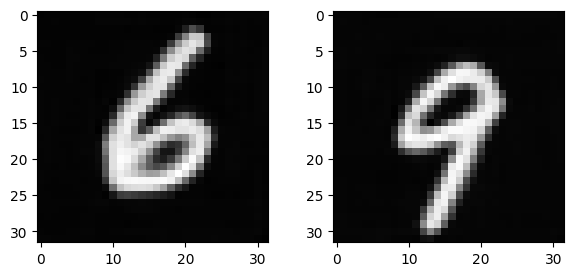

In [44]:
noise = torch.randn(2, Z_DIM).to(device)


images = ema_gen(noise, use_truncation=True).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(images[0], cmap="gray")
axs[1].imshow(images[1], cmap="gray");

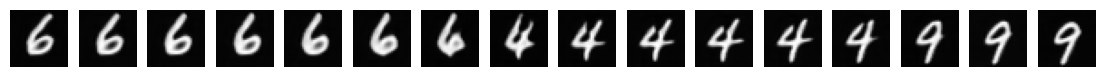

In [45]:
intermediate_noise = ema_gen.noise_mapping(noise)
intermediate_noise = ema_gen.truncation_sampling(intermediate_noise)

cnt = 15
step = (intermediate_noise[1] - intermediate_noise[0]) / cnt
interpolated_noises = []
for i in range(cnt+1):
    interpolated_noises.append(intermediate_noise[0] + step * i)
interpolated_w = torch.stack(interpolated_noises).unsqueeze(1).expand(-1, ema_gen.num_steps, -1)
interpolated_images = ema_gen.generator_synthesis(w=interpolated_w).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, cnt+1, figsize=(14, 2))
for i in range(cnt+1):
    axs[i].axis("off")
    axs[i].imshow(interpolated_images[i], cmap="gray")

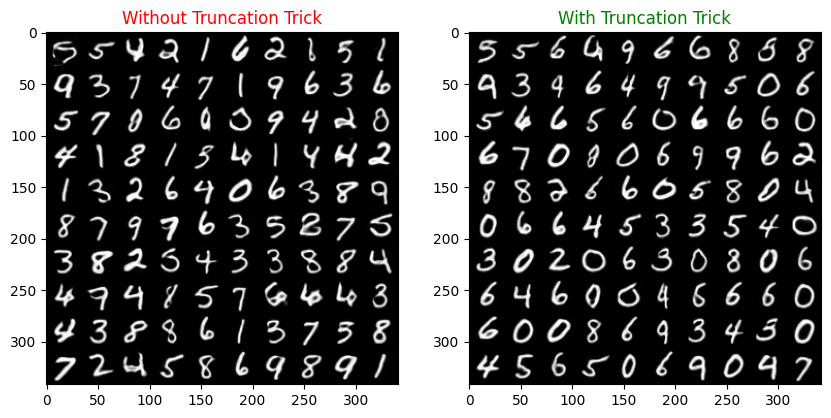

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

noise = torch.randn(100, Z_DIM).to(device)
w = ema_gen.noise_mapping(noise).unsqueeze(1).expand(-1, ema_gen.num_steps, -1)
imgs = ema_gen.generator_synthesis(w).detach().cpu()
imgs = torchvision.utils.make_grid((imgs + 1) / 2, nrow=10)
imgs = imgs.permute(1, 2, 0).clip(0, 1).numpy()

axs[0].set_title("Without Truncation Trick", c='red')
axs[0].imshow(imgs);

w = ema_gen.noise_mapping(noise)
w = ema_gen.truncation_sampling(w).unsqueeze(1).expand(-1, ema_gen.num_steps, -1)
imgs = ema_gen.generator_synthesis(w=w).detach().cpu()
imgs = torchvision.utils.make_grid((imgs + 1) / 2, nrow=10)
imgs = imgs.permute(1, 2, 0).clip(0, 1).numpy()

axs[1].set_title("With Truncation Trick", c='green')
axs[1].imshow(imgs);

### Training on CelebA-HQ $(128 \times 128)$

In [30]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    AdjustPixelsRange(range_in=(0., 1.), range_out=(-1., 1.))
])

dataset = torchvision.datasets.ImageFolder(root='../../data/celeba_hq', transform=transform)

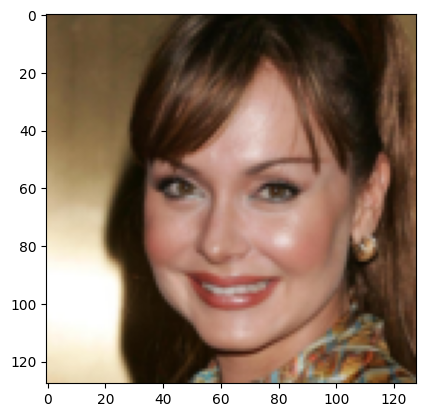

In [31]:
plt.imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(dataset[1][0].permute(1, 2, 0)));

In [32]:
Z_DIM = 512
BATCH_SIZE = 16
NUM_CRITIC_UPDATE = 1
GP_LAMBDA = 10
DRIFT_LAMBDA = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"

CRIT_REGULARIZER_STEP = 16

print(device)

cuda


In [33]:
gen = Generator(z_dim=Z_DIM, w_dim=512, image_size=128, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128]).to(device)
ema_gen = copy.deepcopy(gen)
update_exponential_moving_average_generator(ema_gen, gen, decay=0)
crit = Discriminator(image_size=128, image_channels=3, steps_in_channels=[128, 256, 512, 512, 512, 512]).to(device)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)
C_CRIT = CRIT_REGULARIZER_STEP/(CRIT_REGULARIZER_STEP+1)
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.001*C_CRIT, betas=(0.**C_CRIT, 0.99**C_CRIT), eps=1e-8)

logistic_gan_loss = LogisticGANLoss(crit, device=device)

In [34]:
from_checkpoint = True

if from_checkpoint:
    state_root = 'results_celebahq/'

    gen.load_state_dict(torch.load(os.path.join(state_root, 'gen.pth')))
    ema_gen.load_state_dict(torch.load(os.path.join(state_root, 'ema_gen.pth')))
    crit.load_state_dict(torch.load(os.path.join(state_root, 'crit.pth')))
    opt_gen.load_state_dict(torch.load(os.path.join(state_root, 'opt_gen.pth')))
    opt_crit.load_state_dict(torch.load(os.path.join(state_root, 'opt_crit.pth')))

    state = torch.load(os.path.join(state_root, 'state.pth'))
else:
    state = {}

    update_exponential_moving_average_generator(ema_gen, gen, decay=0)

state

{'epoch': 66}

In [38]:
fixed_noise = generate_fixed_noise((36, Z_DIM), seed=123).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(40):
    epoch_start_time = time.time()
    
    gen.train()
    for iter_idx, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        #----- Updating the Discriminator -----#
        for _ in range(NUM_CRITIC_UPDATE):
            noise = torch.randn(real_images.shape[0], Z_DIM).to(device)
            fake_images = gen(noise).detach()
            pred_real, pred_fake = crit(real_images), crit(fake_images)
            loss = logistic_gan_loss.disc_loss(real_images, fake_images, r1_gamma=0.)
            crit.zero_grad()
            loss.backward()
            opt_crit.step()

            if iter_idx != 0 and iter_idx % CRIT_REGULARIZER_STEP == 0:
                loss = logistic_gan_loss.r1_penalty(real_images) * CRIT_REGULARIZER_STEP
                crit.zero_grad()
                loss.backward()
                opt_crit.step()


        update_exponential_moving_average_generator(ema_gen, gen)

        #----- Updating the Generator -----#
        noise = torch.randn(BATCH_SIZE, Z_DIM).to(device)
        loss = logistic_gan_loss.gen_loss(gen(noise))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

        # TODO: Seems like this hurts the performance!!!
        # if iter_idx != 0 and iter_idx % GEN_REGULARIZER_STEP == 0:
        #     loss = ppl_loss.get_loss(gen, noise) * GEN_REGULARIZER_STEP * 0.001
        #     loss_logger.info(f"GAN PPL Loss: {loss:.8f}")
        #     gen.zero_grad()
        #     loss.backward()
        #     opt_gen.step()


    gen.eval()
    ema_gen.eval()

    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Epoch {epoch} [Epoch time: {time.time() - epoch_start_time}]")
    generate_images_and_save(gen, epoch, fixed_noise, "results_celebahq/gen_images", nrow=6)
    generate_images_and_save(ema_gen, epoch, fixed_noise, "results_celebahq/ema_gen_images", nrow=6)
    generate_images_and_save(ema_gen, epoch, fixed_noise, "results_celebahq/ema_gen_images_with_truncation", use_truncation=True, nrow=6)

    save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"epoch": epoch}, 'results_celebahq/')
    if epoch % 5 == 0:
        save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"epoch": epoch}, f'results_celebahq/epoch-{epoch}/')

## Evaluation

### Interpolation

In [35]:
ema_gen.eval();

In [36]:
ema_gen.truncation_sampling.w_avg = ema_gen.noise_mapping(torch.randn(10000, Z_DIM).to(device)).detach().mean(axis=0)
# ema_gen.truncation_sampling.psi = 0.5

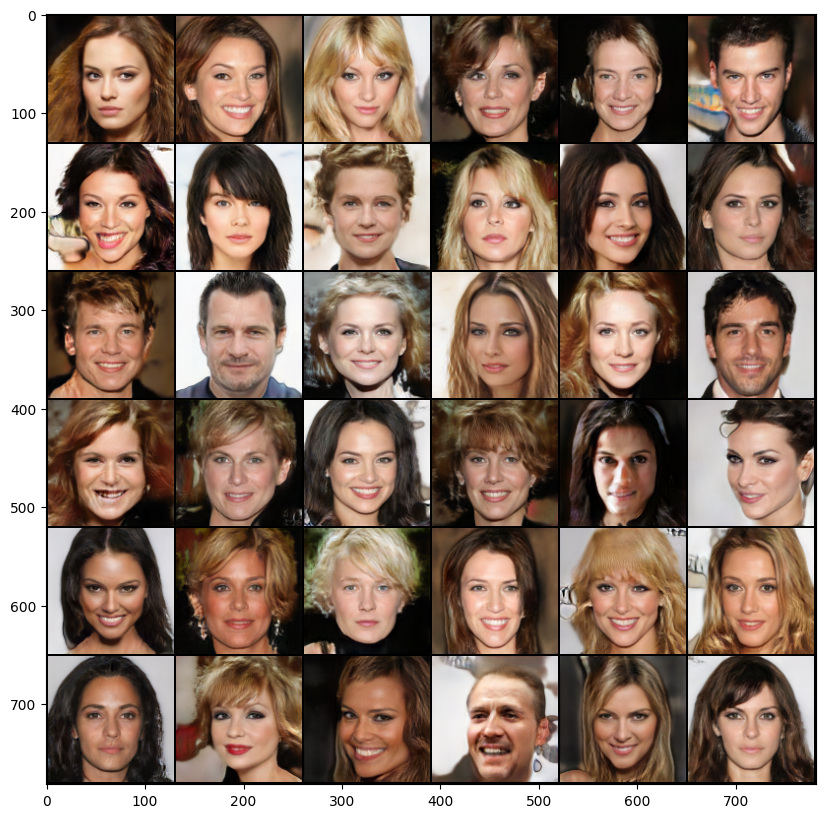

In [46]:
fixed_noise = torch.randn(36, Z_DIM).to(device)

fixed_w = ema_gen.noise_mapping(fixed_noise).unsqueeze(1).expand(-1, ema_gen.num_steps, -1)
fixed_w = ema_gen.truncation_sampling(fixed_w)

generated_images_from_fixed_noise = ema_gen.generator_synthesis(fixed_w).detach().cpu()

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_images_from_fixed_noise), nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

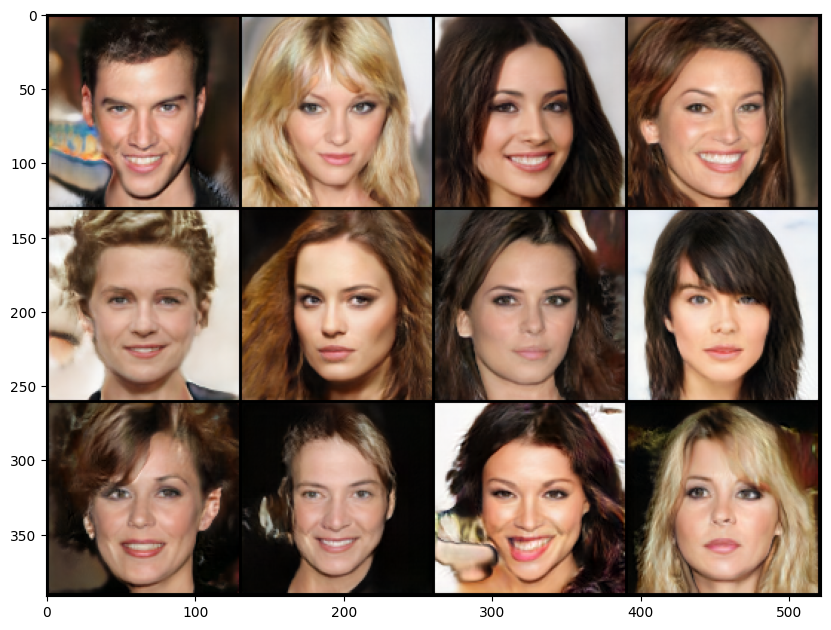

In [47]:
import random

# selected_indices = [1, 3, 5, 9, 10, 11, 12, 13, 14, 22, 30, 31, 34, 40, 41, 44, 55, 59, 60, 63]
selected_indices = list(range(12))
random.shuffle(selected_indices)

selected_noises = fixed_noise[selected_indices]
selected_w = fixed_w[selected_indices]

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_images_from_fixed_noise[selected_indices]), nrow=4).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### Effect of Stochastic Variation (Noise Injection)

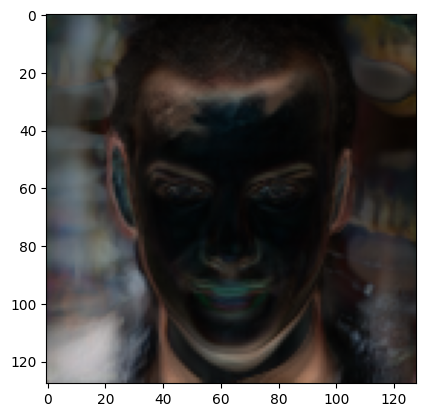

In [48]:
multiple_instances_of_the_same_w = selected_w[0].unsqueeze(0).expand(30, -1, -1)
generated_images_of_the_same_w = ema_gen.generator_synthesis(multiple_instances_of_the_same_w)

std_of_generated_images = torch.std(generated_images_of_the_same_w, dim=0).detach().cpu()

plt.imshow(std_of_generated_images.permute(1, 2, 0));

In [66]:
import cv2

video = cv2.VideoWriter("effect_of_stochastic_noise_tmp.avi", cv2.VideoWriter_fourcc(*'DIVX'), 10, (128, 128))
ff = lambda x: (((x + 1) / 2).clip(0, 1) * 255).numpy().astype(np.uint8)
for img in generated_images_of_the_same_w.detach().cpu():
    video.write(cv2.cvtColor(ff(img.permute(1, 2, 0)), cv2.COLOR_BGR2RGB))
video.release()
cv2.destroyAllWindows()

In [ ]:
import moviepy.editor

def avi_to_gif(input_file, output_file):
    video = moviepy.editor.VideoFileClip(input_file)
    video.write_gif(output_file)

avi_to_gif("effect_of_stochastic_noise.avi", "effect_of_stochastic_noise.gif")

MoviePy - Building file effect_of_stochastic_noise.gif with imageio.


<img src="effect_of_stochastic_noise.gif" width=200>

#### Switching off Stochastic Variation

In [49]:
zero_injected_noise_arr = generate_fixed_stochastic_noise(batch_size=12, model=ema_gen, device=device)
for idx, _ in enumerate(zero_injected_noise_arr):
    zero_injected_noise_arr[idx] = zero_injected_noise_arr[idx] * 0.

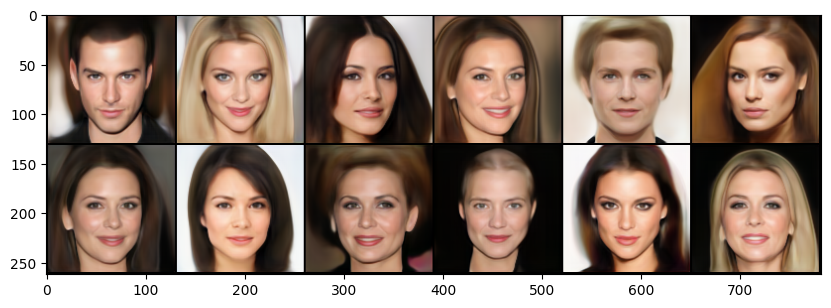

In [50]:
img = ema_gen.generator_synthesis(selected_w, stochastic_noise=zero_injected_noise_arr).detach().cpu()
plt.figure(figsize=(10, 10))
plt.imshow(torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(img), nrow=6).permute(1, 2, 0));

#### Interpolation

In [45]:
single_fixed_stochastic_noise = generate_fixed_stochastic_noise(batch_size=1, model=ema_gen, device=device)

In [52]:
result_w = []
cnt = 10
fixed_stochastic_noise = expand_single_fixed_noise_to_batch(single_fixed_stochastic_noise, batch_size=cnt)
percentage = torch.linspace(0, 1, cnt).view(cnt, 1).to(selected_noises[0].device)
for i in range(len(selected_noises)):
    j = i+1 if i < len(selected_noises)-1 else 0

    intermediate_w = (selected_w[i][0] * (1 - percentage)) + (selected_w[j][0] * percentage)
    intermediate_w = intermediate_w.unsqueeze(1).expand(-1, ema_gen.num_steps, -1)

    intermediate_images_w = ema_gen.generator_synthesis(intermediate_w, stochastic_noise=fixed_stochastic_noise).detach().cpu().permute(0, 2, 3, 1)

    result_w.extend([*intermediate_images_w])

In [54]:
import cv2

video = cv2.VideoWriter("output_w.avi", cv2.VideoWriter_fourcc(*'DIVX'), 7, (128, 128))
ff = lambda x: (((x + 1) / 2).clip(0, 1) * 255).numpy().astype(np.uint8)
for img in result_w:
    video.write(cv2.cvtColor(ff(img), cv2.COLOR_BGR2RGB))
video.release()
cv2.destroyAllWindows()

In [ ]:
avi_to_gif("output_w.avi", "output_w.gif")

MoviePy - Building file output_w.gif with imageio.


<img src="output_w.gif" width=200>

### Style Transfer

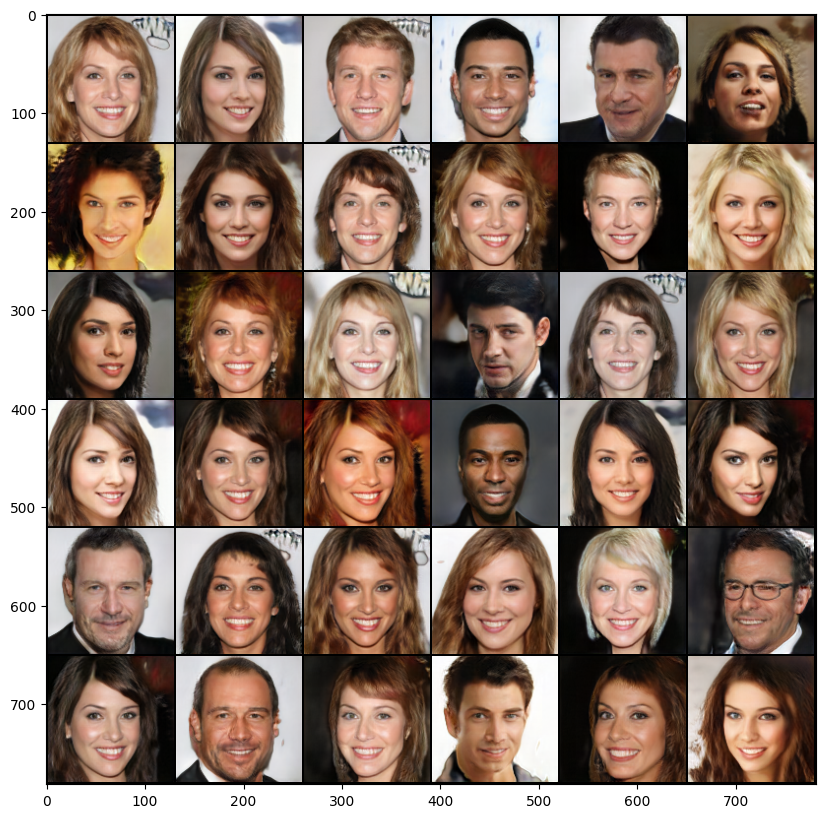

In [56]:
fixed_noise = torch.randn(36, Z_DIM).to(device)

fixed_w = ema_gen.noise_mapping(fixed_noise).unsqueeze(1).expand(-1, ema_gen.num_steps, -1)
fixed_w = ema_gen.truncation_sampling(fixed_w)

generated_images_from_fixed_noise = ema_gen.generator_synthesis(fixed_w, stochastic_noise=expand_single_fixed_noise_to_batch(single_fixed_stochastic_noise, batch_size=36)).detach().cpu()

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_images_from_fixed_noise), nrow=6).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### Source B

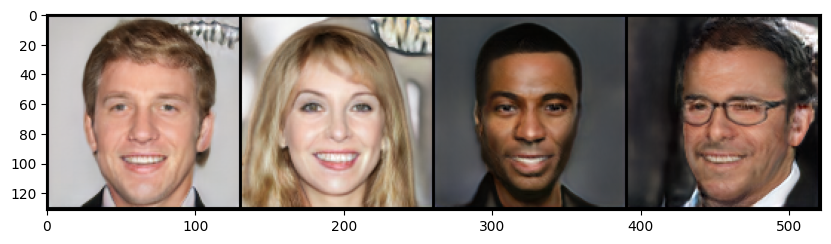

In [59]:
source_B_indices = [2, 14, 21, 29]

source_B_noises = fixed_noise[source_B_indices]
source_B_w = fixed_w[source_B_indices]

source_B_images = generated_images_from_fixed_noise[source_B_indices]

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(source_B_images), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### Source A

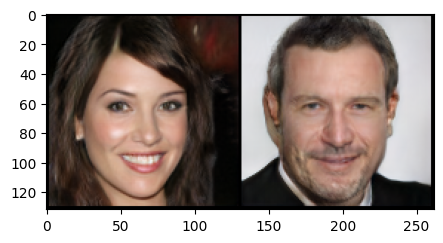

In [60]:
source_A_indices = [30, 24]

source_A_noises = fixed_noise[source_A_indices]
source_A_w = fixed_w[source_A_indices]

source_A_images = generated_images_from_fixed_noise[source_A_indices]

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(source_A_images), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(5, 5))
plt.imshow(img);

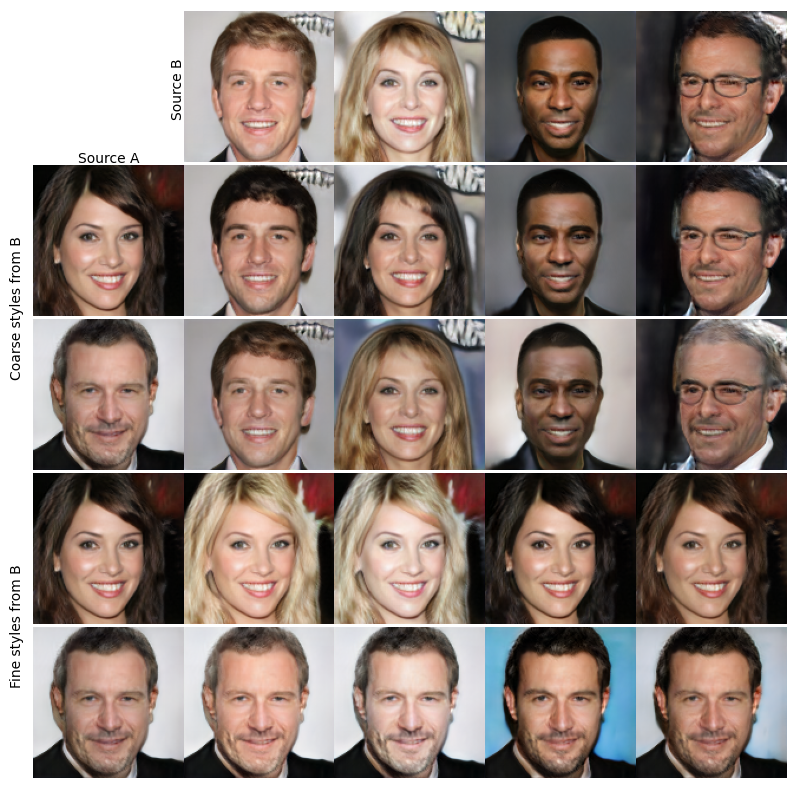

In [61]:
cut_off_coarse = 2
cut_off_fine = 3

nrows, ncols = 5, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))

for i in range(nrows):
    for j in range(ncols):
        axs[i][j].axis('off')

for i in range(1, 5):
    axs[0][i].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(source_B_images[i-1].permute(1, 2, 0)))

# Coarse style transfer
for i in range(len(source_A_indices)):
    axs[i+1][0].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(source_A_images[i].permute(1, 2, 0)))
    for j in range(len(source_B_indices)):
        combined_w = torch.cat((source_B_w[j][:cut_off_coarse], source_A_w[i][cut_off_coarse:]), dim=0).unsqueeze(0)
        generated_img = ema_gen.generator_synthesis(combined_w, stochastic_noise=single_fixed_stochastic_noise).detach().cpu()
        axs[i+1][j+1].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_img[0].permute(1, 2, 0)))

# Fine style transfer
for i in range(len(source_A_indices)):
    axs[i+3][0].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(source_A_images[i].permute(1, 2, 0)))
    for j in range(len(source_B_indices)):
        combined_w = torch.cat((source_A_w[i][:cut_off_fine], source_B_w[j][cut_off_fine:]), dim=0).unsqueeze(0)
        generated_img = ema_gen.generator_synthesis(combined_w, stochastic_noise=single_fixed_stochastic_noise).detach().cpu()
        axs[i+3][j+1].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_img[0].permute(1, 2, 0)))

axs[1][0].text(0.3, 1.02, 'Source A', transform=axs[1][0].transAxes)
axs[0][1].text(-0.08, 0.3, 'Source B', rotation=90, transform=axs[0][1].transAxes)

axs[1][0].text(-0.15, -0.4, 'Coarse styles from B', rotation=90, transform=axs[1][0].transAxes)
axs[3][0].text(-0.15, -0.4, 'Fine styles from B', rotation=90, transform=axs[3][0].transAxes)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


In [ ]:
# TODO : Transfer styles for stochastic noise as well